In [1]:
# Pip 安装命令
!pip install segmentation-models-pytorch
# !pip install lightning
!pip install wandb -U
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.6 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f4f01e13f1285ab760ba7415912c88bde98eb2bbada6fa97b83deda64507d792
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8a385445de4acb7c0d2271a782dad245b2389e4baec92c61f69f48df0778ac5a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [13]:
# 导入的库
import IPython
import ipywidgets
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.tuner.tuning import Tuner
from IPython.display import display
import numpy as np
import nibabel as nib
import os
from os.path import join
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2
import monai
from monai.losses import *
import pytorch_lightning as pl
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import LightningDataModule
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from fastai.losses import *
import torchmetrics
import wandb
# from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.core.mixins import HyperparametersMixin
from pytorch_lightning.callbacks import Callback
IPython.display.clear_output()

print("Envirionment Set Up.")

Envirionment Set Up.


# Dataset and Augment Setting

In [14]:
# 定义数据增强
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.08, alpha_affine=120 * 0.015),
    A.RandomSizedCrop(min_max_height=(128, 256), height=256, width=256, p=0.3),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

In [16]:
def adjust_window(image, window_center, window_width):
    """
    调整CT图像的窗宽窗位。
    :param image: 输入的图像数组。
    :param window_center: 窗位（WC）。
    :param window_width: 窗宽（WW）。
    :return: 调整窗宽窗位后的图像。
    """
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(image, img_min, img_max)
    # print(windowed_img.dtype) # NOW its float64
    return windowed_img

class MultipleImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        image_paths: 图像文件路径列表
        label_paths: 标签文件路径列表
        transform: 应用于图像和标签的转换操作
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        # 假设图像和标签列表长度相等
        return len(self.image_paths)

    def __getitem__(self, idx): # dataloader获取每个数据都会用到这个函数，所以你应当在这里实现你需要的
                                # 预处理等等步骤
        image = (np.load(self.image_paths[idx]))['arr_0'] 
#         print(image.shape)
        label = (np.load(self.label_paths[idx]))['arr_0']
#         print(label.shape)

        image = adjust_window(image, window_center=40, window_width=400)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
#             print("image aug")
            label = augmented['mask']
            image = image.float()
            label = label.long()

        label = label.long()
        # normalize image here based on its value accordingly
        image = (image - image.min()) / (image.max() - image.min())
        # print(image.unique())
#         print(f"label shape: {label.shape}")
#         print(image.shape)
        return image.float(), label.long()
######################################################################################################################
class MOADataModule(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int = 16):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        image_dir = os.path.join(self.data_dir, 'image_npz')  # 注意这里路径的更正
        label_dir = os.path.join(self.data_dir, 'mask_npz')

        # 读取文件路径
        image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.npz')])
        label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npz')])

        # 划分训练集、验证集、测试集
        train_size = int(0.8 * len(image_files))
        val_size = int(0.1 * len(image_files))

        self.train_image_paths = image_files[:train_size]
        self.val_image_paths = image_files[train_size:train_size + val_size]
        self.test_image_paths = image_files[train_size + val_size:]

        self.train_label_paths = label_files[:train_size]
        self.val_label_paths = label_files[train_size:train_size + val_size]
        self.test_label_paths = label_files[train_size + val_size:]

    def train_dataloader(self):
        train_dataset = MultipleImageDataset(self.train_image_paths, self.train_label_paths, transform=self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def val_dataloader(self):
        val_dataset = MultipleImageDataset(self.val_image_paths, self.val_label_paths, transform=self.val_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    def test_dataloader(self):
        test_dataset = MultipleImageDataset(self.test_image_paths, self.test_label_paths, transform=self.val_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 定义数据集和数据加载器
# data_dir = '/kaggle/input/brats2018'
data_dir='/kaggle/input/rawniidataset/SMU_Dataset'

def predict_and_log_images(num_samples=2):
    
    # 假设 test_loader 和 model 已经定义好了，并且 model 已经移动到了适当的设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = data_module.test_dataloader()
    
    # 生成随机索引
    indices = torch.randperm(len(test_loader.dataset))[:num_samples]
    # 调整subplot的大小
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))  # 每个样本显示3张图（原图、真实掩码、预测掩码）

    for i, idx in enumerate(indices):
        image, mask = test_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # 添加batch维度并移动到设备
        mask = mask.squeeze()  # 移除batch维度（如果有的话）

        with torch.no_grad():
            pred = model(image)
            prediction = torch.argmax(pred, dim=1).cpu()  # 获取预测类别并移回CPU

        # 显示原始图像
        axs[i, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].set_title(f'Original Image {i+1}')
        axs[i, 0].axis('off')

        # 显示Ground Truth
        axs[i, 1].imshow(mask.cpu().numpy(), cmap='gray')
        axs[i, 1].set_title(f'True Mask {i+1}')
        axs[i, 1].axis('off')

        # 显示预测掩码
        axs[i, 2].imshow(prediction[0].numpy(), cmap='gray')
        axs[i, 2].set_title(f'Predicted Mask {i+1}')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.close(fig)  # 防止在notebook中显示图像
    return fig


# 自定义回调，用于在验证结束时执行操作
class ValidationCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        print("Validation epoch ended. Executing custom actions...")
        # 假设test_loader已经在pl_module（即您的model）中定义
        # 或者您可以在这里直接访问datamodule的test_dataloader
#         test_loader = pl_module.test_dataloader()
        
        # 确保模型处于评估模式
#         pl_module.eval()
#         print("eval activated")

        # 执行自定义的预测和绘图逻辑
        fig = predict_and_log_images(num_samples=2)
        # 用wandb记录图像，或进行其他操作
        wandb.log({"Validation Callback Predicted Images": wandb.Image(fig)})

# (Opt) Data Pre-Check

Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [ 0  1  3  4  6  7  8  9 10 11 12 13]
Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [0 5 6 8 9]
Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [ 0  2  3  6  7  8  9 11]
Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [ 0  1  6  7  8  9 10 11]


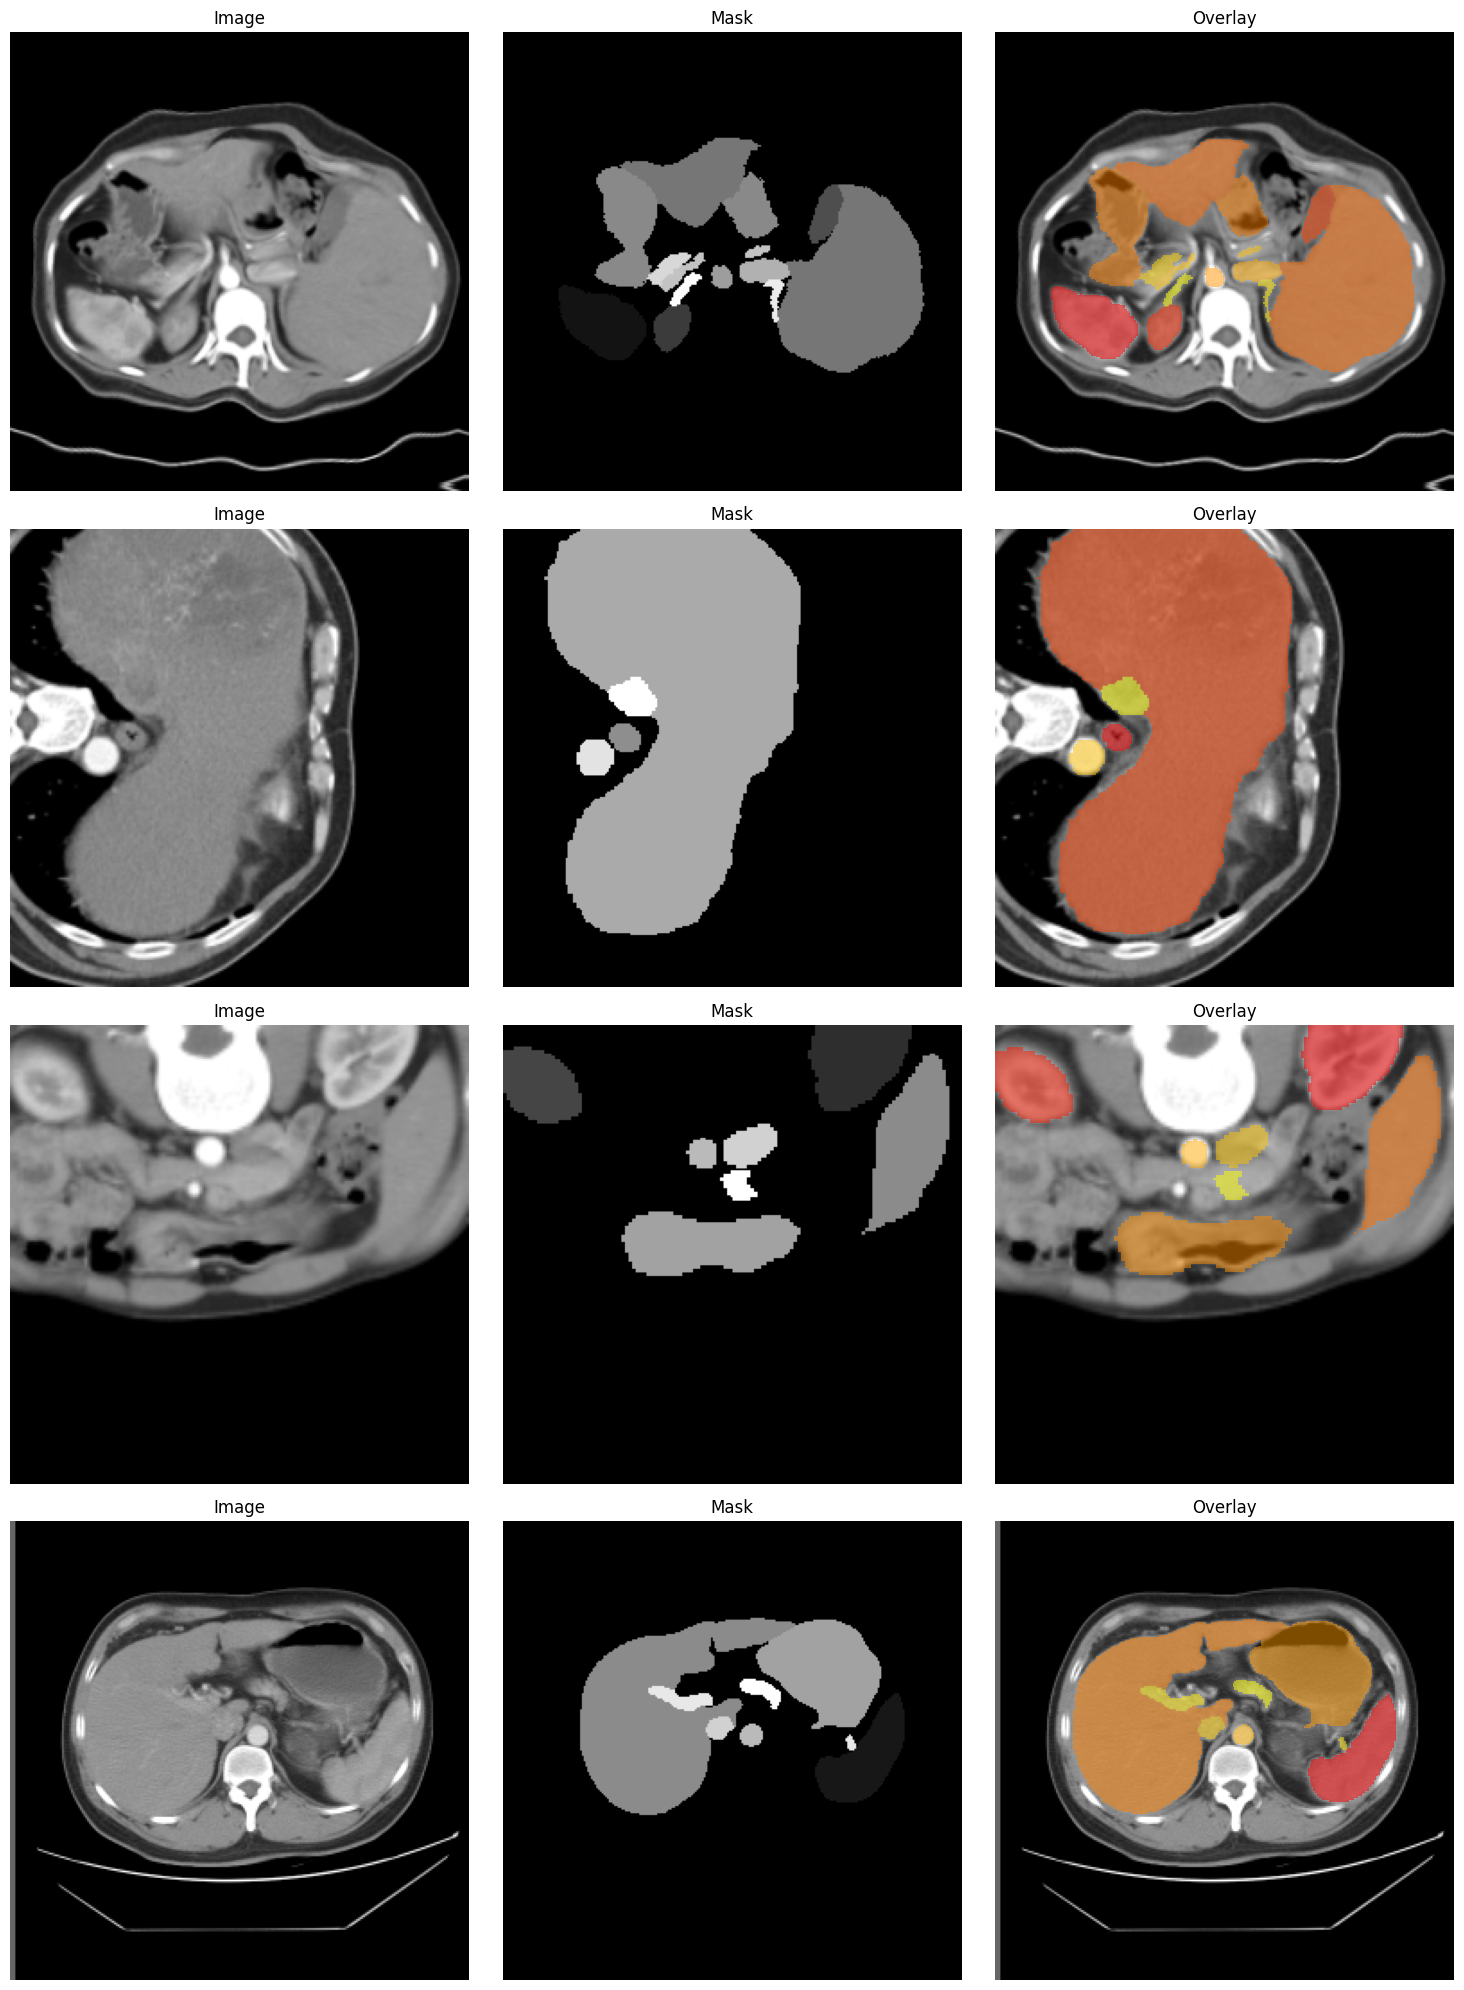

Show Time!


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 初始化数据模块
data_module = MOADataModule(data_dir='/kaggle/input/rawniidataset/SMU_Dataset', batch_size=16)
# data_module = MOADataModule(data_dir='/kaggle/input/brats2018', batch_size=16)


# 设置数据模块（准备数据）
data_module.setup()

# 获取训练数据加载器
train_loader = data_module.train_dataloader()

# 从数据加载器中抽取一批数据
images, labels = next(iter(train_loader))

# 选择要展示的图像数量
num_images_to_show = 4

# 创建图表来展示图像和对应的掩码
fig, axs = plt.subplots(num_images_to_show, 3, figsize=(15, num_images_to_show * 5))

for i in range(num_images_to_show):
    img = images[i].squeeze().numpy()  # 假设图像和掩码都只有一个通道
    lbl = labels[i].squeeze().numpy()
    overlay = np.ma.masked_where(lbl == 0, lbl)
    
    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(lbl, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')
    
    axs[i, 2].imshow(img, cmap='gray')
    axs[i, 2].imshow(overlay, cmap='autumn', alpha=0.5)
    axs[i, 2].set_title('Overlay')
    axs[i, 2].axis('off')
    
    print(f"Image shape: {img.shape}")
    print(f"Label shape: {lbl.shape}")
    print(f"Image M&m Value: {img.max(), img.min()}")
    print(f"Label Unique: {np.unique(lbl)}")

plt.tight_layout()
plt.show()
print('Show Time!')

# Model Setting

In [18]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
#         print(f"x1 Shape is: {x1.shape}")
#         print(f"x2 Shape is: {x2.shape}")
#         print(f"x Shape is: {x.shape}")
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=14, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
#         print(f"Input shape: {x.shape}")
        x1 = self.inc(x)
#         print(f"After inc (DoubleConv): {x1.shape}")
        x2 = self.down1(x1)
#         print(f"After down1: {x2.shape}")
        x3 = self.down2(x2)
#         print(f"After down2: {x3.shape}")
        x4 = self.down3(x3)
#         print(f"After down3: {x4.shape}")
        x5 = self.down4(x4)
#         print(f"After down4: {x5.shape}")

        x = self.up1(x5, x4)
#         print(f"After up1 (with skip connection from down3): {x.shape}")
        x = self.up2(x, x3)
#         print(f"After up2 (with skip connection from down2): {x.shape}")
        x = self.up3(x, x2)
#         print(f"After up3 (with skip connection from down1): {x.shape}")
        x = self.up4(x, x1)
#         print(f"After up4 (with skip connection from inc): {x.shape}")

        logits = self.outc(x)
#         print(f"Output shape (after OutConv): {logits.shape}")
        return logits


    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [19]:
# from monai.transforms import AsDiscrete
class UNetTestModel(pl.LightningModule, HyperparametersMixin):
    def __init__(
        self,
        encoder_name='resnet50',
        encoder_weights='imagenet',
        in_channels=1,
        classes=14,
#         loss_fn=monai.losses.FocalLoss(use_softmax=True, to_onehot_y=True, include_background=False),
        loss_fn=monai.losses.DiceCELoss(softmax=True,lambda_dice=0.85, lambda_ce=0.15, to_onehot_y=True),
#         loss_fn=monai.losses.DiceLoss( to_onehot_y=True),
        loss_function='DiceCELoss',
        learning_rate=5e-3,
#         train_accuracy_params={'task': "multiclass", 'num_classes': 14, 'average': 'macro'},
#         val_accuracy_params={'task': "multiclass", 'num_classes': 14, 'average': 'macro'},
#         dice_params={'multiclass': True, 'num_classes': 14, 'average': 'macro'},  
        bilinear=False,
        ):
        super().__init__()
        self.save_hyperparameters()
        ###################### model #########################
        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
#             decoder_attention_type='scse',
        )
#         self.model = UNet(in_channels, classes, bilinear=bilinear)
        ###################### loss ##########################
        self.loss_fn = loss_fn
        ###################### metrics ######################
#         self.train_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes, average='micro', ignore_index=0)
        self.val_accuracy_MACRO = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes, average='macro', ignore_index=0)
        self.val_accuracy_micro = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes, average='micro', ignore_index=0)
        self.Dice = torchmetrics.classification.Dice(multiclass=True, num_classes=classes, average='macro', ignore_index=0)
        self.F1 = torchmetrics.classification.MulticlassF1Score(num_classes=classes, average="macro", ignore_index=0)
        self.Jaccard = torchmetrics.classification.MulticlassJaccardIndex(num_classes=classes, average="macro", ignore_index=0)
        #####################################################
#         Outputs Shape: torch.Size([1, 14, 256, 256])
#         Labels Shape: torch.Size([1, 256, 256])
#         Labels Shape After Unsqueeze: torch.Size([1, 1, 256, 256])
#         Predictions Shape: torch.Size([1, 256, 256])


    # 定义前向传播
    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.loss_fn(outputs, labels.unsqueeze(1))

#         acc = self.train_accuracy(outputs, labels)
#         Dice = self.Dice(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=False, logger=True, prog_bar=True)
#         self.log('train_accuracy', acc, on_step=True, on_epoch=False, logger=True, prog_bar=True)
#         self.log('train_Dice', Dice, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
#         print("val_step going")
        images, labels = batch
        outputs = self.forward(images)
        loss = self.loss_fn(outputs, labels.unsqueeze(1))
        preds = torch.argmax(outputs, dim=1)
        

#         print(labels_one_hot.shape)
        acc_micro = self.val_accuracy_micro(preds, labels)
        acc_MACRO = self.val_accuracy_MACRO(preds, labels)
        Dice = self.Dice(preds, labels)
        F1 = self.F1(preds, labels)
        Jaccard = self.Jaccard(preds, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=False, logger=True, prog_bar=True)
#         for i,acc in enumerate(acc):
#             self.log(f'val_accuracy_MACRO_{i}', acc, on_step=True, on_epoch=False,logger=True, prog_bar=True)
#         for i,F1 in enumerate(F1):
#             self.log(f'val_F1_{i}', F1, on_step=True, on_epoch=False,logger=True, prog_bar=True)
        self.log('val_accuracy_micro', acc_micro, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_accuracy_MACRO', acc_MACRO, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_F1', F1, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_Dice', Dice, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_Jaccard', Jaccard, on_step=True, on_epoch=False, logger=True, prog_bar=True)

        
        
#     def test_step(self, batch, batch_idx):
#         images, labels = batch
#         outputs = self.forward(images)
#         loss = self.loss_fn(outputs, labels.unsqueeze(1))

#         preds = torch.argmax(outputs, dim=1)
#         acc_MACRO = self.val_accuracy_MACRO(preds, labels)  # 注意: 在测试阶段，我们仍然可以使用val_accuracy_MACRO
#         Dice = self.Dice(preds, labels)
#         self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         self.log('test_accuracy', acc_MACRO, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         self.log('test_Dice', Dice, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         # 这里没有wandb.log调用，因为PyTorch Lightning的self.log已经足够记录所有指标

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure, **kwargs):
        # 调用优化器的step方法前执行自定义操作
        # 比如实现学习率热启动
        if self.trainer.global_step < 25:
            lr_scale = min(1.0, float(self.trainer.global_step + 1) / 25)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.hparams.learning_rate
        # 调用优化器的step方法来更新模型参数
        optimizer.step(closure=optimizer_closure)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, verbose=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001, last_epoch=-1)
#         print(self.hparams.learning_rate)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # 指定更新学习率的间隔单位为'epoch'
                'frequency': 1,  # 每个epoch更新一次学习率
            }
        }

# (Opt) Hyper Params Check

In [20]:
from torchinfo import summary
model = UNetTestModel()
print(summary(model, input_size=(1,1,256,256)))
print(model.hparams)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


Layer (type:depth-idx)                             Output Shape              Param #
UNetTestModel                                      [1, 14, 256, 256]         --
├─Unet: 1-1                                        [1, 14, 256, 256]         --
│    └─ResNetEncoder: 2-1                          [1, 1, 256, 256]          --
│    │    └─Conv2d: 3-1                            [1, 64, 128, 128]         3,136
│    │    └─BatchNorm2d: 3-2                       [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                              [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [1, 256, 64, 64]          215,808
│    │    └─Sequential: 3-6                        [1, 512, 32, 32]          1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 16, 16]         7,098,368
│    │    └─Sequential: 3-8                        [1, 2048, 8, 8]           14,964,736
│   

# (Opt) Pre-Train Test

In [21]:
data_module = MOADataModule(data_dir=data_dir, batch_size=1)
# avail test
model = UNetTestModel()
lr_monitor = LearningRateMonitor(logging_interval='step')
############################################## fastrun ###################################################
trainer = pl.Trainer(max_epochs=20, 
                     fast_dev_run=True, 
#                      callbacks=[lr_monitor, ValidationCallback()],
#                      check_val_every_n_epoch=10, 
                    )
trainer.fit(model, datamodule=data_module)

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
data_module = MOADataModule(data_dir=data_dir, batch_size=1)
# learnability test
wandb_logger_test = WandbLogger()
# # 初始化Trainer，设置overfit_batches来过拟合一小部分数据
# lr_monitor = LearningRateMonitor(logging_interval='step')
test_trainer = pl.Trainer(overfit_batches=1, 
                          logger=wandb_logger_test, 
#                           callbacks=[lr_monitor, ValidationCallback()], 
                          check_val_every_n_epoch=1)

# # 或者，使用10个批次的数据来过拟合
# test_trainer = pl.Trainer(overfit_batches=10, logger=wandb_logger_test)

# 运行训练
test_trainer.fit(model, datamodule=data_module)
wandb.finish()

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,▆██▄▄▄▂▂▂▂▁▂▁▁▂▄▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_Dice,▁▁▁▁▁▁▁▁▁▁▂▃▁▃▆▂▁▃▄▁█▂▂▁▁▃▃▂▂▁▄▃▅▁▃▃▃▄▅▂
val_F1,▁▁▁▁▁▁▁▂▁▁▄▄▁▃▆▃▁▆▃▁█▃▃▁▁▅▄▃▃▁▆▅▅▁▂▃▃▆▅▃
val_Jaccard,▁▁▁▁▁▁▁▁▁▁▃▄▁▃▇▃▁▇▂▁█▂▃▁▁▅▄▃▃▁▆▅▄▁▂▃▂▆▅▂
val_accuracy_MACRO,▁▁▁▁▁▁▁▂▁▁▃▄▁▃▆▄▁▇▄▁█▃▃▁▁▅▄▂▃▁▆▄▄▁▁▃▂▆▄▂
val_accuracy_micro,▁▁▁▁▁▁▁▂▁▁▃▄▁▃▇▃▁█▄▁█▂▃▁▁▅▄▂▃▁▆▄▄▁▁▃▂▆▄▂
val_loss,▃▃▁▁▂▁█▁▃▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
train_loss,0.5561


# Sweeps

In [ ]:
sweep_config = {
  'method': 'random', 
  'metric': {
    'name': 'val_loss',
    'goal': 'minimize'}, 
  'parameters': {
    'learning_rate': {
      'min': 0.0001,
      'max': 0.1},
    'batch_size': {
      'values': [16, 32, 64]}
    }
}
wandb_logger = WandbLogger()
sweep_id = wandb.sweep(sweep_config, project="test sweeps2")
lr_monitor = LearningRateMonitor(logging_interval='step')

def sweep_train():
    with wandb.init() as run:
        config = wandb.config
        model = UNetTestModel(
            learning_rate=config.learning_rate,
#             batch_size=config.batch_size,
            # 其他参数...
        )
        trainer = pl.Trainer(
            max_epochs=150,
            callbacks=[lr_monitor, ValidationCallback()],
            logger=wandb_logger,
#             check_val_every_n_epoch=10,
            # 其他设置...
        )
        data_module = MOADataModule(data_dir=data_dir, batch_size=config.batch_size)
        trainer.fit(model, datamodule=data_module)

wandb.agent(sweep_id, function=sweep_train, count=10)


# Lightning Style Formal Test

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='step')
# 假设你已经定义了 LiTSDataModule
data_module = MOADataModule(data_dir=data_dir, batch_size=16)
# 初始化模型和训练器
model = UNetTestModel(bilinear=False)

# wandb_logger = WandbLogger(project="SMU MOA", name="ResUNetPP50_monaiDiceCELoss_Max150")
wandb_logger = WandbLogger(project="UNet Baseline", name="Origin_UNet_noAtt_Max150_DiceCELoss")
# wandb_logger = WandbLogger()


trainer = Trainer(max_epochs=150, 
#                      fast_dev_run=True, 
                  logger=wandb_logger, 
#                   callbacks=[lr_monitor, ValidationCallback()],
                  callbacks=[lr_monitor],
                  log_every_n_steps=1,
                  check_val_every_n_epoch=1,
#                   precision='16-mixed',
                  )


# 创建 Tuner 对象并运行学习率查找
# tuner = Tuner(trainer)
# lr_finder = tuner.lr_find(model, datamodule=data_module)

# # 可视化找到的学习率
# fig = lr_finder.plot(suggest=True)
# display(fig)

# # 将建议的学习率设置给模型
# new_lr = lr_finder.suggestion()
# model.hparams.learning_rate = new_lr


# 注意：在此处，你不需要手动更新 DataLoader 的批量大小
# 因为 tuner.scale_batch_size 方法已经更新了 LiTSDataModule 中的 batch_size
# 你可以检查更新后的批量大小
# tuner.scale_batch_size(model, datamodule=data_module, mode="power")
# print(f"Updated batch size: {data_module.batch_size}")

# 使用更新后的学习率继续训练
trainer.fit(model, datamodule=data_module)

In [ ]:
# 确保模型处于评估模式
model.eval()
print("eval activated")



def predict_and_log_images(num_samples=2):
    
    # 假设 test_loader 和 model 已经定义好了，并且 model 已经移动到了适当的设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = data_module.test_dataloader()
    
    # 生成随机索引
    indices = torch.randperm(len(test_loader.dataset))[:num_samples]
    # 调整subplot的大小
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))  # 每个样本显示3张图（原图、真实掩码、预测掩码）

    for i, idx in enumerate(indices):
        image, mask = test_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # 添加batch维度并移动到设备
        mask = mask.squeeze()  # 移除batch维度（如果有的话）

        with torch.no_grad():
            pred = model(image)
            prediction = torch.argmax(pred, dim=1).cpu()  # 获取预测类别并移回CPU

        # 显示原始图像
        axs[i, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].set_title(f'Original Image {i+1}')
        axs[i, 0].axis('off')

        # 显示Ground Truth
        axs[i, 1].imshow(mask.cpu().numpy(), cmap='gray')
        axs[i, 1].set_title(f'True Mask {i+1}')
        axs[i, 1].axis('off')

        # 显示预测掩码
        axs[i, 2].imshow(prediction[0].numpy(), cmap='gray')
        axs[i, 2].set_title(f'Predicted Mask {i+1}')
        axs[i, 2].axis('off')

    plt.tight_layout()
#     plt.close(fig)  # 防止在notebook中显示图像
    return fig

In [ ]:
# 循环十次，每次都记录图像
for _ in range(10):
    fig = predict_and_log_images(num_samples=2)
    wandb.log({"Predicted Images": wandb.Image(fig)})

In [ ]:
results = trainer.test(dataloaders=data_module.val_dataloader())
print(results)

In [ ]:
# 创建一个新的Artifact，指定其类型为'model'和Artifact的名称
artifact = wandb.Artifact('ResUNetPP50_monaiDiceCELoss_Max150', type='model')
artifact.add_file('/kaggle/working/SMU MOA/vq9tunx5/checkpoints/epoch=149-step=4950.ckpt')

# 保存Artifact到wandb
wandb.log_artifact(artifact)

In [ ]:
wandb.finish()